**Created by:** Revekka Gershovich

**When:** Dec 3, 2024

**Purpose:** Cleaning state partisan composition data

**Next file:** merging_Klarner_and_ICPSR.ipynb

Note that Republican and Democratic parties are actually a number of ancestor and closely aligned parties commonly considered together by political scientist merged into one. That is why there is data for Republican party before 1854. Democrats (1 in pres_gov_party) also contain a Jackson (Democrats) party (1829-1854). Republicans (2 in pres_gov_party) also contain Whig party (1834-1856), Anti-Jacksonian party (1824-1837), and Opposition Coalition which includes Whig + Republican + Free Soil parties (1850-1856). 

In [264]:
import os
import os.path as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [265]:
parent_dir = os.path.abspath("/Users/revekkagershovich/Dropbox (MIT)/StateLaws")
os.chdir(parent_dir)
assert os.path.exists(parent_dir), "parent_dir does not exist"
intermed_data_dir = "./2_data/2_intermediate/political_data"
assert os.path.exists(intermed_data_dir), "Data directory does not exist"
raw_data_dir = "./2_data/1_raw/political_data/all_partisanComposition"
assert os.path.exists(raw_data_dir), "Data directory does not exist"

The CSVs I am loading here were produced using R code called converting_icspr16_to_csv.R because somebody wrote asciiSetupReader library for R so as to extract filed from ACSII format using SAS or SPSS setup files - this setup was only used before 2000s and thus this is a very niche library. 

In [266]:
data_codes = data_codes = [f"{i:04d}" for i in range(1, 6)] 
# I am only cleaning the first three datasets even though two more exists because I have better data from Carl Klarner for the later years

print(data_codes)

['0001', '0002', '0003', '0004', '0005']


In [267]:
dataframes = {}

for data_code in data_codes:
    data_file = f"ICPSR_00016_2/DS{data_code}/00016-{data_code}-Data.csv"
    data_path = path.join(raw_data_dir, data_file)
    print(data_path)
    assert os.path.exists(data_path), "Data file does not exist"
    df = pd.read_csv(data_path)
    # Save the dataframe in the dictionary
    dataframes[f"df_{data_code}"] = df

    # Print confirmation
    print(f"DataFrame for {data_code} loaded successfully.")


./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0001/00016-0001-Data.csv
DataFrame for 0001 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0002/00016-0002-Data.csv
DataFrame for 0002 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0003/00016-0003-Data.csv
DataFrame for 0003 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0004/00016-0004-Data.csv
DataFrame for 0004 loaded successfully.
./2_data/1_raw/political_data/all_partisanComposition/ICPSR_00016_2/DS0005/00016-0005-Data.csv
DataFrame for 0005 loaded successfully.


In [268]:
df = dataframes["df_0001"]

In [269]:
df = df.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT"
columns_to_drop = [col for col in df.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df = df.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT'
seat_columns = [col for col in df.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df[seat_columns] = df[seat_columns]/10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df = df.rename(columns=renamed_columns)

columns_to_transform = [col for col in df.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df = df.melt(id_vars=["ICPR_STATE_CODE"], 
                    value_vars=columns_to_transform, 
                    var_name="year_variable", 
                    value_name="value")

# Extract year and variable from the melted column
melted_df["year"] = melted_df["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df["variable"] = melted_df["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df = melted_df.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df = melted_df.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                    columns="variable", 
                                    values="value").reset_index()

non_pct_columns = [col for col in reshaped_df.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df[non_pct_columns] = reshaped_df[non_pct_columns].astype('Int64') 

I am mapping in the next cell the following parties to republicans and democrats: 
Democratic (100 - 1): 
Republican (200 - 2): Whigs (29), Opposition (Whigs + nascent Republicans + American) (34)

310 – AMERICAN – republican (2) 
311 - AMERICAN and REPUBLICAN – republican (2) 
35 - LAW AND ORDER WHIG – republican (2) 
768 - REPUBLICAN AMERICAN – republican (2) 
1063 - OPPOSITION – republican (2) 
843  - FUSION - drop
553 - UNION - drop
315 - WHIG AND AMERICAN – republican (2) 
636 - EQUAL RIGHTS 
605 - UNION REPUBLICAN – republican (2) 
330 - INDEPENDENT DEMOCRAT - democrat (1)     



In [270]:
# Define the mapping for PARTY_OF_GOV
party_mapping = {
    100: 1,   # Democratic
    330: 1,   # Independent Democrat
    200: 2,   # Republican
    310: 2,   # AMERICAN (Republican)
    311: 2,   # AMERICAN and REPUBLICAN
    35: 2,    # LAW AND ORDER WHIG
    768: 2,   # REPUBLICAN AMERICAN
    1063: 2,  # OPPOSITION (Republican)
    315: 2,   # WHIG AND AMERICAN
    605: 2,   # UNION REPUBLICAN
    843: np.nan,  # FUSION (Drop)
    553: np.nan   # UNION (Drop)
}

# Recode PARTY_OF_GOV using the mapping
reshaped_df['PARTY_OF_GOV'] = reshaped_df['PARTY_OF_GOV'].map(party_mapping)

reshaped_df['PARTY_OF_GOV'] = reshaped_df['PARTY_OF_GOV'].astype('Int64')

Here are ICPR state codes to standartize ICPR_STATE_CODE: https://usa.ipums.org/usa/volii/ICPSR.shtml

In [271]:
state_mapping = {
    41: "AL", 81: "AK", 61: "AZ", 42: "AR", 71: "CA",
    62: "CO", 1: "CT", 11: "DE", 98: "DC", 43: "FL",
    44: "GA", 82: "HI", 63: "ID", 21: "IL", 22: "IN",
    31: "IA", 32: "KS", 51: "KY", 45: "LA", 2: "ME",
    52: "MD", 3: "MA", 23: "MI", 33: "MN", 46: "MS",
    34: "MO", 64: "MT", 35: "NE", 65: "NV", 4: "NH",
    12: "NJ", 66: "NM", 13: "NY", 47: "NC", 36: "ND",
    24: "OH", 53: "OK", 72: "OR", 14: "PA", 5: "RI",
    48: "SC", 37: "SD", 54: "TN", 49: "TX", 67: "UT",
    6: "VT", 40: "VA", 73: "WA", 56: "WV", 25: "WI",
    68: "WY"
}

# Map the ICPR_STATE_CODE to state abbreviations
reshaped_df['state_abbrev'] = reshaped_df['ICPR_STATE_CODE'].map(state_mapping)

In [272]:
reshaped_df.sample(5)

variable,ICPR_STATE_CODE,year,LOW_HSE_DEM_PCT,LOW_HSE_DEM_SEATS,LOW_HSE_TOTAL_SEATS,LOW_HSE_W_R_PCT,LOW_HSE_W_R_SEATS,PARTY_OF_GOV,UPP_HSE_DEM_PCT,UPP_HSE_DEM_SEATS,UPP_HSE_TOTAL_SEATS,UPP_HSE_W_R_PCT,UPP_HSE_W_R_SEATS,state_abbrev
724,44,1872,92.0,161,175,8.0,14,1,90.9,40,44,9.1,4,GA
862,52,1877,77.4,65,84,22.6,19,1,73.1,19,26,26.9,7,MD
605,34,1870,NaN,<NA>,<NA>,NaN,<NA>,1,37.1,13,35,34.3,12,MO
689,43,1845,73.2,30,41,26.8,11,1,64.7,11,17,35.3,6,FL
55,2,1844,65.2,86,132,34.8,46,1,88.0,22,25,12.0,3,ME


In [273]:
print(reshaped_df.isna().sum())

variable
ICPR_STATE_CODE          0
year                     0
LOW_HSE_DEM_PCT         59
LOW_HSE_DEM_SEATS       56
LOW_HSE_TOTAL_SEATS     58
LOW_HSE_W_R_PCT         58
LOW_HSE_W_R_SEATS       55
PARTY_OF_GOV           197
UPP_HSE_DEM_PCT         73
UPP_HSE_DEM_SEATS       72
UPP_HSE_TOTAL_SEATS     71
UPP_HSE_W_R_PCT         73
UPP_HSE_W_R_SEATS       72
state_abbrev             0
dtype: int64


In [274]:
print(f"Number of unique states: {reshaped_df['state_abbrev'].nunique()}")

assert reshaped_df['state_abbrev'].nunique() == 38, "By 1878 there should be 38 states."

assert reshaped_df['year'].min() == 1834, "The minimum year should be 1834."
assert reshaped_df['year'].max() == 1878, "The maximum year should be 1878."
assert reshaped_df['year'].nunique() == 45, "There should be 45 unique years."

Number of unique states: 38


In [275]:
reshaped_df['dem_upphse'] = reshaped_df['UPP_HSE_DEM_SEATS'] / reshaped_df['UPP_HSE_TOTAL_SEATS']


# Ensure proportions are between 0 and 1
assert reshaped_df['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['dem_upphse'] * 100, valid_df['UPP_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

reshaped_df['rep_upphse'] = reshaped_df['UPP_HSE_W_R_SEATS'] / reshaped_df['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['rep_upphse'] * 100, valid_df['UPP_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage."

reshaped_df['dem_lowhse'] = reshaped_df['LOW_HSE_DEM_SEATS'] / reshaped_df['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])
# assert np.allclose(valid_df['dem_lowhse'] * 100, valid_df['LOW_HSE_DEM_PCT'], atol=0.1), \
#     "Proportion of Democratic seats should be equal to the percentage."
# The above assertion fails because there seems to be a single mistake in the data, namely HOW_HSE_DEM_PCT is wrong for VA in 1877. It should be 77.3% instead of 62.1%.
 
reshaped_df['rep_lowhse'] = reshaped_df['LOW_HSE_W_R_SEATS'] / reshaped_df['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats
valid_df = reshaped_df[reshaped_df['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows
assert valid_df['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df = valid_df.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])
assert np.allclose(valid_df['rep_lowhse'] * 100, valid_df['LOW_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage." 

reshaped_df['shr_dem_in_sess'] = (reshaped_df['LOW_HSE_DEM_SEATS'] + reshaped_df['UPP_HSE_DEM_SEATS']) / (reshaped_df['LOW_HSE_TOTAL_SEATS'] + reshaped_df['UPP_HSE_TOTAL_SEATS'])

reshaped_df['shr_rep_in_sess'] = (reshaped_df['LOW_HSE_W_R_SEATS'] + reshaped_df['UPP_HSE_W_R_SEATS']) / (reshaped_df['LOW_HSE_TOTAL_SEATS'] + reshaped_df['UPP_HSE_TOTAL_SEATS'])

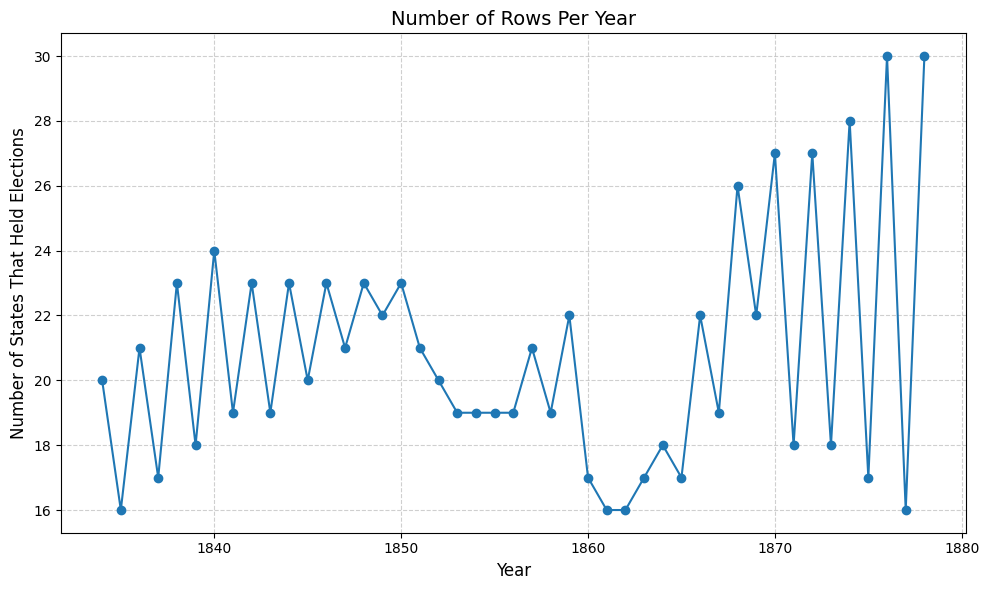

In [276]:
# Exploring occurrences of elections and control switches for odd years
# Count occurrences of each year and sort by year
year_counts = reshaped_df['year'].value_counts().sort_index()

# print(year_counts)

# Plot the counts
plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.title('Number of Rows Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of States That Held Elections', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [277]:
odd_year_df = reshaped_df[reshaped_df['year'] % 2 != 0]

# Initialize results
results = []

# Group by state
for state, group in odd_year_df.groupby('state_abbrev'):
    group = group.sort_values('year')
    
    # Identify years where LOW_HSE_DEM_PCT crosses 50%
    low_crossing_years = group.loc[(group['LOW_HSE_DEM_PCT'] > 50).astype(int).diff().abs() > 0, 'year']
    
    # Identify years where UPP_HSE_DEM_PCT crosses 50%
    upp_crossing_years = group.loc[(group['UPP_HSE_DEM_PCT'] > 50).astype(int).diff().abs() > 0, 'year']
    
    # Identify years where PARTY_OF_GOV changes
    party_change_years = group.loc[group['PARTY_OF_GOV'].diff().abs().gt(0), 'year']
    
    # Combine all years and count unique ones
    unique_years = pd.concat([low_crossing_years, upp_crossing_years, party_change_years]).unique()
    # print(unique_years)
    num_occurrences = len(unique_years)
    
    # Append results for this state
    results.append({
        'state': state,
        'num_occurrences': num_occurrences
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(results_df)

print(f"Number of switches by all states is {results_df['num_occurrences'].sum()}")

   state  num_occurrences
0     AL                4
1     AR                0
2     CA               10
3     CT               11
4     FL                1
5     GA               11
6     IA                0
7     IN                5
8     KY                4
9     LA                3
10    MA                2
11    MD                9
12    ME                5
13    MI                3
14    MN                1
15    MS                6
16    NC                1
17    NH                7
18    NJ               13
19    NY               14
20    OH               12
21    PA               12
22    RI                4
23    SC                0
24    TN                9
25    TX                2
26    VA                9
27    VT                1
28    WI                5
29    WV                0
Number of switches by all states is 164


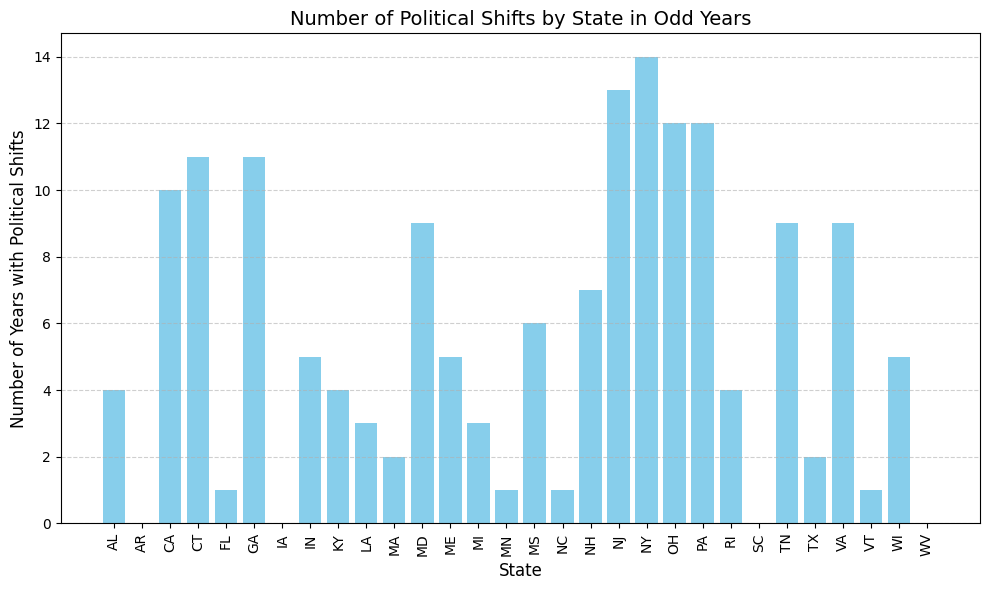

In [278]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['state'], results_df['num_occurrences'], color='skyblue')
plt.title('Number of Political Shifts by State in Odd Years', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Years with Political Shifts', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [279]:
reshaped_df = reshaped_df.drop(columns=['ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT', 
'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS', 'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS', 
'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS'])

reshaped_df = reshaped_df.rename(columns={"PARTY_OF_GOV": "gov_party"})

In [280]:
reshaped_df.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115
1,1835,1,CT,0.761905,0.238095,0.61165,0.38835,0.625551,0.374449
2,1836,1,CT,0.809524,0.190476,0.645631,0.354369,0.660793,0.339207
3,1837,1,CT,0.666667,0.333333,0.660377,0.339623,0.660944,0.339056
4,1838,<NA>,CT,0.047619,0.952381,0.273973,0.726027,0.245509,0.754491


In [281]:
df2 = dataframes["df_0002"]

# Replace 999 and 9999 with NaN (in the setup file missing values were coded this way)
df2 = df2.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT" because they are not relevant since we are analysing on two parties
columns_to_drop = [col for col in df2.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df2 = df2.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT' - these columns represent percentages but have formatting issues to be fixed
seat_columns = [col for col in df2.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df2[seat_columns] = df2[seat_columns] / 10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df2 = df2.rename(columns=renamed_columns)

columns_to_transform = [col for col in df2.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df2 = df2.melt(id_vars=["ICPR_STATE_CODE"], 
                      value_vars=columns_to_transform, 
                      var_name="year_variable", 
                      value_name="value")

# Extract year and variable from the melted column
melted_df2["year"] = melted_df2["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df2["variable"] = melted_df2["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df2 = melted_df2.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df2 = melted_df2.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                      columns="variable", 
                                      values="value").reset_index()

# Identify non-percentage columns (those that do not end with '_PCT')
non_pct_columns = [col for col in reshaped_df2.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df2[non_pct_columns] = reshaped_df2[non_pct_columns].astype('Int64')

# I am re-mapping political parties using the same mapping I defined for the first dataset
reshaped_df2['PARTY_OF_GOV'] = reshaped_df2['PARTY_OF_GOV'].map(party_mapping)

# Convert PARTY_OF_GOV to integer
reshaped_df2['PARTY_OF_GOV'] = reshaped_df2['PARTY_OF_GOV'].astype('Int64')

# Map the ICPR_STATE_CODE to state abbreviations using the state mapping I defined for the first dataset
reshaped_df2['state_abbrev'] = reshaped_df2['ICPR_STATE_CODE'].map(state_mapping)

# Calculate the proportion of Democratic seats in the upper house
reshaped_df2['dem_upphse'] = reshaped_df2['UPP_HSE_DEM_SEATS'] / reshaped_df2['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df2 = reshaped_df2[reshaped_df2['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df2['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Validate that the calculated proportion matches the percentage in the dataset
assert np.allclose(valid_df2['dem_upphse'] * 100, valid_df2['UPP_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the upper house
reshaped_df2['rep_upphse'] = reshaped_df2['UPP_HSE_W_R_SEATS'] / reshaped_df2['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df2 = reshaped_df2[reshaped_df2['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df2['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Validate that the calculated proportion matches the percentage in the dataset
assert np.allclose(valid_df2['rep_upphse'] * 100, valid_df2['UPP_HSE_W_R_PCT'], atol=0.1), \
    "Proportion of Republican seats should be equal to the percentage."

# Calculate the proportion of Democratic seats in the lower house
reshaped_df2['dem_lowhse'] = reshaped_df2['LOW_HSE_DEM_SEATS'] / reshaped_df2['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df2 = reshaped_df2[reshaped_df2['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df2['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])

assert np.allclose(valid_df2['dem_lowhse'] * 100, valid_df2['LOW_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the lower house
reshaped_df2['rep_lowhse'] = reshaped_df2['LOW_HSE_W_R_SEATS'] / reshaped_df2['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df2['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df2 = reshaped_df2[reshaped_df2['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df2['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats should be between 0 and 1."
valid_df2 = valid_df2.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there is a single known mistake in the data, namely LOW_HSE_DEM_PCT is wrong for VA in 1885. It should be 30% instead of 0%.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df2['rep_lowhse'] * 100, valid_df2['LOW_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats should be equal to the percentage."

# Calculate the overall share of Democratic seats in the session (upper + lower house)
reshaped_df2['shr_dem_in_sess'] = (reshaped_df2['LOW_HSE_DEM_SEATS'] + reshaped_df2['UPP_HSE_DEM_SEATS']) / (reshaped_df2['LOW_HSE_TOTAL_SEATS'] + reshaped_df2['UPP_HSE_TOTAL_SEATS'])

# Calculate the overall share of Republican seats in the session (upper + lower house)
reshaped_df2['shr_rep_in_sess'] = (reshaped_df2['LOW_HSE_W_R_SEATS'] + reshaped_df2['UPP_HSE_W_R_SEATS']) / (reshaped_df2['LOW_HSE_TOTAL_SEATS'] + reshaped_df2['UPP_HSE_TOTAL_SEATS'])

# Dropping all the unnecessary columns
reshaped_df2 = reshaped_df2.drop(columns=['ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT', 
'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS', 'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS', 
'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS'])

reshaped_df2 = reshaped_df2.rename(columns={"PARTY_OF_GOV": "gov_party"})


In [282]:
print(f"Number of unique states: {reshaped_df2['state_abbrev'].nunique()}")

assert reshaped_df2['state_abbrev'].nunique() == 48, "By 1922 there should be 48 states."

assert reshaped_df2['year'].min() == 1879, "The minimum year should be 1879."
assert reshaped_df2['year'].max() == 1923, "The maximum year should be 1923."
assert reshaped_df2['year'].nunique() == 45, "There should be 45 unique years."
assert reshaped_df2['gov_party'].nunique() == 2, "There should be 2 unique parties."
valid_values = {1, 2}  
assert reshaped_df2['gov_party'].dropna().isin(valid_values).all(), "All values in 'PARTY_OF_GOV' should be 1, 2, or NaN."

# print(reshaped_df2.isna().sum())

Number of unique states: 48


In [283]:
reshaped_df2.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1879,2,CT,0.238095,0.761905,0.337398,0.658537,0.329588,0.666667
1,1880,2,CT,0.238095,0.761905,0.325203,0.666667,0.318352,0.674157
2,1881,2,CT,0.291667,0.708333,0.405622,0.590361,0.395604,0.600733
3,1882,1,CT,0.458333,0.541667,0.443548,0.556452,0.444853,0.555147
4,1883,1,CT,0.375,0.625,0.37751,0.62249,0.377289,0.622711


In [284]:
# Load the DataFrame
df3 = dataframes["df_0003"]

In [285]:
# Load the DataFrame
df3 = dataframes["df_0003"]

# Replace 999 and 9999 with NaN (in the setup file missing values were coded this way)
df3 = df3.replace([999, 9999], np.nan)

# Identify columns that end with "OTH_SEATS" or "OTH_SEAT" because they are not relevant since we are analysing on two parties
columns_to_drop = [col for col in df3.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df3 = df3.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT' - these columns represent percentages but have formatting issues to be fixed
seat_columns = [col for col in df3.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df3[seat_columns] = df3[seat_columns] / 10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df3 = df3.rename(columns=renamed_columns)

columns_to_transform = [col for col in df3.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df3 = df3.melt(id_vars=["ICPR_STATE_CODE"], 
                      value_vars=columns_to_transform, 
                      var_name="year_variable", 
                      value_name="value")

# Extract year and variable from the melted column
melted_df3["year"] = melted_df3["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df3["variable"] = melted_df3["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df3 = melted_df3.drop(columns=["year_variable"])

# Reshape the DataFrame: each unique variable becomes its column
reshaped_df3 = melted_df3.pivot_table(index=["ICPR_STATE_CODE", "year"], 
                                      columns="variable", 
                                      values="value").reset_index()

# Identify non-percentage columns (those that do not end with '_PCT')
non_pct_columns = [col for col in reshaped_df3.columns if not col.endswith('_PCT')]

# Convert these columns to integers
reshaped_df3[non_pct_columns] = reshaped_df3[non_pct_columns].astype('Int64')

# I am re-mapping political parties using the same mapping I defined for the first dataset
reshaped_df3['PARTY_OF_GOV'] = reshaped_df3['PARTY_OF_GOV'].map(party_mapping)

# Convert PARTY_OF_GOV to integer
reshaped_df3['PARTY_OF_GOV'] = reshaped_df3['PARTY_OF_GOV'].astype('Int64')

# Map the ICPR_STATE_CODE to state abbreviations using the state mapping I defined for the first dataset
reshaped_df3['state_abbrev'] = reshaped_df3['ICPR_STATE_CODE'].map(state_mapping)

# Calculate the proportion of Democratic seats in the upper house
reshaped_df3['dem_upphse'] = reshaped_df3['UPP_HSE_DEM_SEATS'] / reshaped_df3['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df3 = reshaped_df3[reshaped_df3['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df3['dem_upphse'].between(0, 1).all(), "Proportion of Democratic seats in senate should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['UPP_HSE_DEM_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# # Validate that the calculated proportion matches the percentage in the dataset
# Note: This assertion is commented out because there are three known mistakes in the data: clearly percentages for years 1966 and 1968 in SC are switched. MA has a mistake in 1974. The percentage should be 84.1% instead of 92.5%.
# variable  ICPR_STATE_CODE state_abbrev  year  UPP_HSE_DEM_PCT  dem_upphse
# 80                      3           MA  1974             92.5    0.840909
# 779                    48           SC  1966             94.0        0.88
# 780                    48           SC  1968             88.0        0.94
# assert np.allclose(valid_df3['dem_upphse'] * 100, valid_df3['UPP_HSE_DEM_PCT'], atol=0.1), \
#     "Proportion of Democratic seats in the Senate should be equal to the percentage."

# Calculate the proportion of Republican seats in the upper house
reshaped_df3['rep_upphse'] = reshaped_df3['UPP_HSE_W_R_SEATS'] / reshaped_df3['UPP_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats in senate should be between 0 and 1."

# Filter rows with valid total seats in the upper house
valid_df3 = reshaped_df3[reshaped_df3['UPP_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df3['rep_upphse'].between(0, 1).all(), "Proportion of Republican seats in the Senate should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['UPP_HSE_W_R_SEATS', 'UPP_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there are three known mistakes in the data: the percentages are missing for year
# 1974 (for all or most states), and for SC additionally in 1966 and 1968. I have concerns re: how reliable this data is.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df3['rep_upphse'] * 100, valid_df3['UPP_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats in the Senate should be equal to the percentage."

# Calculate the proportion of Democratic seats in the lower house
reshaped_df3['dem_lowhse'] = reshaped_df3['LOW_HSE_DEM_SEATS'] / reshaped_df3['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats in the House of Representatives should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df3 = reshaped_df3[reshaped_df3['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Democratic seat proportions
assert valid_df3['dem_lowhse'].between(0, 1).all(), "Proportion of Democratic seats the House of Representatives should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['LOW_HSE_DEM_SEATS', 'LOW_HSE_TOTAL_SEATS'])

assert np.allclose(valid_df3['dem_lowhse'] * 100, valid_df3['LOW_HSE_DEM_PCT'], atol=0.1), \
    "Proportion of Democratic seats should be equal to the percentage."

# Calculate the proportion of Republican seats in the lower house
reshaped_df3['rep_lowhse'] = reshaped_df3['LOW_HSE_W_R_SEATS'] / reshaped_df3['LOW_HSE_TOTAL_SEATS']

# Ensure proportions are between 0 and 1
assert reshaped_df3['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats in the House of Representatives should be between 0 and 1."

# Filter rows with valid total seats in the lower house
valid_df3 = reshaped_df3[reshaped_df3['LOW_HSE_TOTAL_SEATS'] > 0]

# Perform assertions on the valid rows for Republican seat proportions
assert valid_df3['rep_lowhse'].between(0, 1).all(), "Proportion of Republican seats the House of Representatives should be between 0 and 1."
valid_df3 = valid_df3.dropna(subset=['LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS'])

# Note: This assertion is commented out because there are three known mistakes in the data: the percentages are missing for year
# 1974 (for all or most states), and for SC additionally in 1966 and 1968. I have concerns re: how reliable this data is.
# # Validate that the calculated proportion matches the percentage in the dataset
# assert np.allclose(valid_df3['rep_lowhse'] * 100, valid_df3['LOW_HSE_W_R_PCT'], atol=0.1), \
#     "Proportion of Republican seats in the House of Representatives should be equal to the percentage."

# Calculate the overall share of Democratic seats in the session (upper + lower house)
reshaped_df3['shr_dem_in_sess'] = (reshaped_df3['LOW_HSE_DEM_SEATS'] + reshaped_df3['UPP_HSE_DEM_SEATS']) / (reshaped_df3['LOW_HSE_TOTAL_SEATS'] + reshaped_df3['UPP_HSE_TOTAL_SEATS'])

# Calculate the overall share of Republican seats in the session (upper + lower house)
reshaped_df3['shr_rep_in_sess'] = (reshaped_df3['LOW_HSE_W_R_SEATS'] + reshaped_df3['UPP_HSE_W_R_SEATS']) / (reshaped_df3['LOW_HSE_TOTAL_SEATS'] + reshaped_df3['UPP_HSE_TOTAL_SEATS'])

# Dropping all the unnecessary columns
reshaped_df3 = reshaped_df3.drop(columns=[
    'ICPR_STATE_CODE', 'UPP_HSE_DEM_PCT', 'UPP_HSE_W_R_PCT',
    'LOW_HSE_DEM_PCT', 'LOW_HSE_W_R_PCT', 'LOW_HSE_DEM_SEATS',
    'LOW_HSE_W_R_SEATS', 'UPP_HSE_DEM_SEATS', 'UPP_HSE_W_R_SEATS',
    'UPP_HSE_TOTAL_SEATS', 'LOW_HSE_TOTAL_SEATS', 'LOW_HSE_10TH_PCT', 
    'LOW_HSE_20TH_PCT', 'LOW_HSE_2_OTH_SEATS.1', 'LOW_HSE_REP_PCT', 
    'PARTY_CODE_OF_GOV','PARTY_OF_GOV.1', 'UPP_HSE_10TH_PCT', 
    'UPP_HSE_20TH_PCT', 'UPP_HSE_REP_PCT',
])

# Rename PARTY_OF_GOV column for clarity
reshaped_df3 = reshaped_df3.rename(columns={"PARTY_OF_GOV": "gov_party"})

In [286]:
# # Identify rows where the assertion fails - can be modified for any failing assertion
# failing_rows = valid_df3[
#     ~np.isclose(valid_df3['rep_lowhse'] * 100, valid_df3['LOW_HSE_W_R_PCT'], atol=0.1)
# ]

# print(failing_rows.shape)

# # Print the failing rows
# print(failing_rows[['ICPR_STATE_CODE', 'state_abbrev', 'year', 'LOW_HSE_W_R_SEATS', 'LOW_HSE_TOTAL_SEATS', 'LOW_HSE_DEM_SEATS', 'rep_lowhse', 'LOW_HSE_W_R_PCT']])

In [287]:
reshaped_df3['year'].max()

1974

In [288]:
print(f"Number of unique states: {reshaped_df3['state_abbrev'].nunique()}")

assert reshaped_df3['state_abbrev'].nunique() == 50, "By 1922 there should be 50 states."

assert reshaped_df3['year'].min() == 1924, "The minimum year should be 1924."
assert reshaped_df3['year'].max() == 1974, "The maximum year should be 1974."
assert reshaped_df3['year'].nunique() == 51, "There should be 51 unique years."
assert reshaped_df3['gov_party'].nunique() == 2, "There should be 2 unique parties."
valid_values = {1, 2}  
assert reshaped_df3['gov_party'].dropna().isin(valid_values).all(), "All values in 'PARTY_OF_GOV' should be 1, 2, or NaN."

Number of unique states: 50


In [289]:
df4 = dataframes["df_0004"]
print(df4['YEAR_OF_LEGISLATURE'].min())
print(df4['YEAR_OF_LEGISLATURE'].max())

df5 = dataframes["df_0005"]
# Identify columns that end with "OTH_SEATS" or "OTH_SEAT"
columns_to_drop = [col for col in df5.columns if col.endswith("OTH_SEATS") or col.endswith("OTH_SEAT")]

# Drop these columns from the DataFrame
df5 = df5.drop(columns=columns_to_drop)

# Identify columns ending with '_SEAT'
seat_columns = [col for col in df5.columns if col.endswith('_SEAT')]

# Correct the formatting by dividing these columns by 10 - Due to formatting issues with the data, the point was lost as well as the percentage sign in the name of the column.
df5[seat_columns] = df5[seat_columns]/10

# The columns ending with SEAT actually represent percentages. I will use them to corroborate my own calculations of proportions since I cannot trust the data due to formatting mistakes
renamed_columns = {col: col.replace('_SEAT', '_PCT') for col in seat_columns}
df5 = df5.rename(columns=renamed_columns)

columns_to_transform = [col for col in df5.columns if col.startswith("X")]

# Melt the DataFrame to stack all relevant columns
melted_df5 = df5.melt(id_vars=["ICPSR_STATE_CODE"], 
                    value_vars=columns_to_transform, 
                    var_name="year_variable", 
                    value_name="value")

# Extract year and variable from the melted column
melted_df5["year"] = melted_df5["year_variable"].str.extract(r'X(\d{3,4})').astype(int) + 1000  # Convert year to 1800s format
melted_df5["variable"] = melted_df5["year_variable"].str.split("_", n=1).str[1]

# Drop the original column with combined year and variable
melted_df5 = melted_df5.drop(columns=["year_variable"])
print(melted_df5['year'].min())
print(melted_df5['year'].max())

834
974
1975
1985


In [290]:
icpsr_df = pd.concat([reshaped_df, reshaped_df2, reshaped_df3], axis=0)

In [291]:
icpsr_df.head()

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115
1,1835,1,CT,0.761905,0.238095,0.61165,0.38835,0.625551,0.374449
2,1836,1,CT,0.809524,0.190476,0.645631,0.354369,0.660793,0.339207
3,1837,1,CT,0.666667,0.333333,0.660377,0.339623,0.660944,0.339056
4,1838,<NA>,CT,0.047619,0.952381,0.273973,0.726027,0.245509,0.754491


In [292]:
icpsr_df.to_csv(os.path.join(intermed_data_dir, "icpsr.csv"), index=False)

It is clear that df5 is just a continuation of df3 for years 1975-1985. Df4 is the same data but presented by year. We do not need either. 

**Next file:** merging_Klarner_and_ICPSR.ipynb

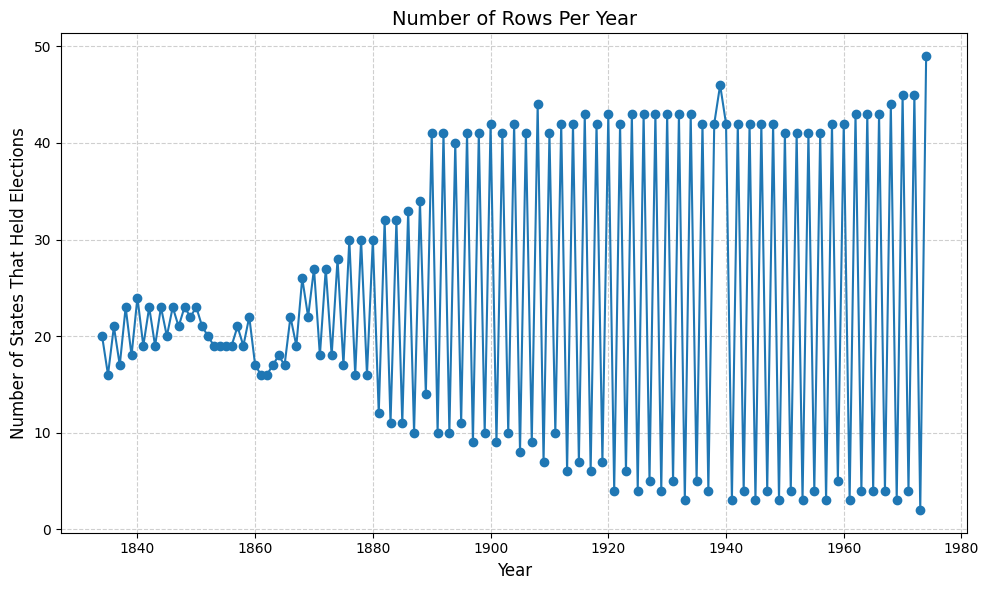

In [293]:
# Exploring occurrences of elections and control switches for odd years
# Count occurrences of each year and sort by year
year_counts = icpsr_df['year'].value_counts().sort_index()

# print(year_counts)

# Plot the counts
plt.figure(figsize=(10, 6))
plt.plot(year_counts.index, year_counts.values, marker='o')
plt.title('Number of Rows Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of States That Held Elections', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [296]:
icpsr_df.head(1)

variable,year,gov_party,state_abbrev,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
0,1834,<NA>,CT,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115


In [300]:
odd_year_df = icpsr_df[icpsr_df['year'] % 2 != 0]

# Initialize results
results = []

# Group by state
for state, group in odd_year_df.groupby('state_abbrev'):
    group = group.sort_values('year')
    
    # Identify years where dem_lowhse crosses 50%
    low_crossing_years = group.loc[(group['dem_lowhse'].fillna(0) > 0.5).astype(int).diff().abs() > 0, 'year']

    # Identify years where dem_upphse crosses 50%
    upp_crossing_years = group.loc[(group['dem_upphse'].fillna(0) > 0.5).astype(int).diff().abs() > 0, 'year']
    
    # Identify years where gov_party changes
    party_change_years = group.loc[group['gov_party'].diff().abs().gt(0), 'year']
    
    # Combine all years and count unique ones
    unique_years = pd.concat([low_crossing_years, upp_crossing_years, party_change_years]).unique()
    # print(unique_years)
    num_occurrences = len(unique_years)
    
    # Append results for this state
    results.append({
        'state': state,
        'num_occurrences': num_occurrences
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# print(results_df)

print(f"Number of switches by all states is {results_df['num_occurrences'].sum()}")

Number of switches by all states is 274


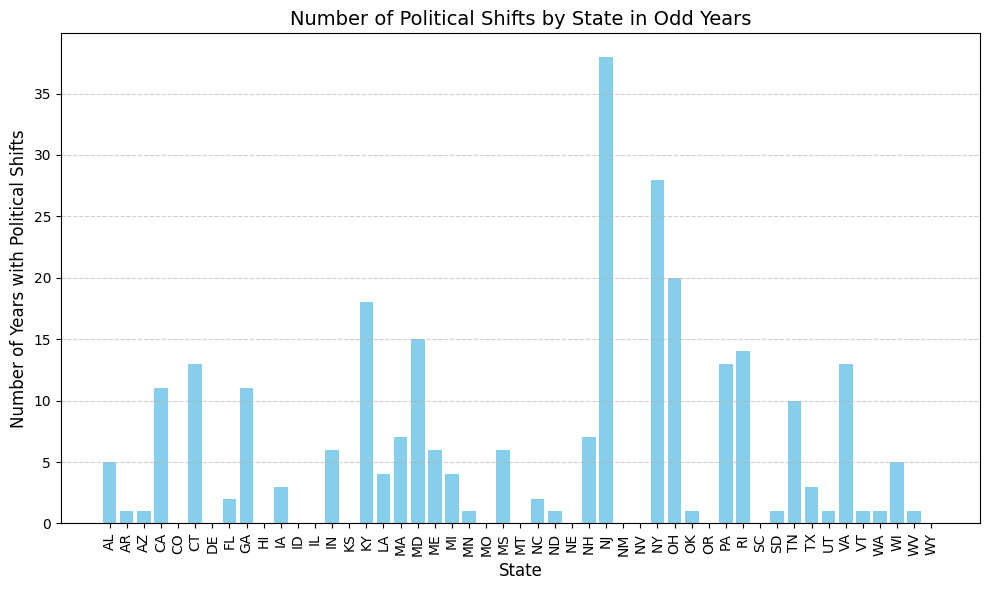

In [301]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['state'], results_df['num_occurrences'], color='skyblue')
plt.title('Number of Political Shifts by State in Odd Years', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Years with Political Shifts', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()